In [2]:
import sys
import torch

seed = 42
#torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy
import matplotlib.pyplot as plt 
import seaborn as sns
import fiora.IO.mspReader as mspReader
# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree
import fiora.visualization.spectrum_visualizer as sv
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder
from fiora.GNN.GNNModules import GNNCompiler
from fiora.MS.SimulationFramework import SimulationFramework

from fiora.MOL.collision_energy import NCE_to_eV
from fiora.MS.spectral_scores import spectral_cosine, spectral_reflection_cosine, reweighted_dot
from fiora.MS.ms_utility import merge_annotated_spectrum
from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from sklearn.model_selection import train_test_split
print(f'Working with Python {sys.version}')


[15:47:36] WARNING: not removing hydrogen atom without neighbors
[15:47:36] WARNING: not removing hydrogen atom without neighbors
[15:47:36] WARNING: not removing hydrogen atom without neighbors


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


### Model

In [3]:
depth = 6
v: str = "0.1.0"
MODEL_PATH = f"../models/fiora_OS_v{v}.pt" # Release version
#MODEL_PATH="../../checkpoint_training.best.pt"
#MODEL_PATH="../../../checkpoint_RGCNConv.best.pt"
#MODEL_PATH="../../../checkpoint_all_wells_new.best.pt"
#MODEL_PATH="../Checkpoints/checkpoint_test_new_mona_tuned.best.pt"
#MODEL_PATH="../../../checkpoint_mona_ft_rounded_3dec_5ppm.best.pt"
try:
    model = GNNCompiler.load_from_state_dict(MODEL_PATH)
except:
    raise NameError("Error: Failed loading from state dict.")
model.model_params    

{'param_tag': 'default',
 'gnn_type': 'RGCNConv',
 'depth': 6,
 'hidden_dimension': 300,
 'dense_layers': 2,
 'embedding_aggregation': 'concat',
 'embedding_dimension': 300,
 'input_dropout': 0.2,
 'latent_dropout': 0.1,
 'node_feature_layout': {'symbol': 10, 'num_hydrogen': 5, 'ring_type': 5},
 'edge_feature_layout': {'bond_type': 4, 'ring_type': 5},
 'static_feature_dimension': 8,
 'static_rt_feature_dimension': 7,
 'output_dimension': 10,
 'atom_features': ['bond_type', 'ring_type'],
 'setup_features': ['collision_energy',
  'molecular_weight',
  'precursor_mode',
  'instrument'],
 'setup_features_categorical_set': {'instrument': ['HCD'],
  'precursor_mode': ['[M+H]+', '[M-H]-', '[M]+', '[M]-']},
 'rt_features': ['molecular_weight', 'precursor_mode', 'instrument'],
 'rt_supported': False,
 'ccs_supported': False,
 'version': 'Fiora OS v0.1.0',
 'training_label': 'compiled_probsSQRT',
 'version_number': '0.1.0',
 'training_library': 'MSnLib',
 'comment': 'This is the first open-sourc

In [4]:
has_m_plus = False
if "setup_features_categorical_set" in model.model_params.keys():
    print(model.model_params["setup_features_categorical_set"]["precursor_mode"])
    if "[M]+" in model.model_params["setup_features_categorical_set"]["precursor_mode"]:
        has_m_plus = True

['[M+H]+', '[M-H]-', '[M]+', '[M]-']


## Data

In [5]:
# key map to read metadata from pandas DataFrame
metadata_key_map = {
                "name": "Name",
                 "collision_energy":  "CE", 
                "instrument": "Instrument_type",
                "ionization": "Ionization",
               "precursor_mz": "PrecursorMZ",
                "precursor_mode": "Precursor_type",      
                 "retention_time": "RT",
                 "ccs": "CCS"
                 }


def load_training_data(input_file):
    L = LibraryLoader()
    df = L.load_from_csv(input_file)
    return df
    
def restore_dict(df):
    dict_columns = ["peaks"]#, "summary"]
    for col in dict_columns:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    df['group_id'] = df['group_id'].astype(int)
    
    return df

def train_val_test_split(keys, test_size=0.1, val_size=0.1, rseed=seed): ######################################### Dont forget to change ( 0.1 0.1)
    temp_keys, test_keys = train_test_split(keys, test_size=test_size, random_state=rseed)
    adjusted_val_size = val_size / (1 - test_size)
    train_keys, val_keys = train_test_split(temp_keys, test_size=adjusted_val_size, random_state=rseed)
    
    return train_keys, val_keys, test_keys
def add_grouping(df):
    print("Split into training, testing and validation")
    group_ids = df["group_id"].astype(int)
    keys = np.unique(group_ids)
    example_not_in_test_split = True
    
    for i in range(100):
        train, val, test = train_val_test_split(keys, rseed=seed + i)
    df["dataset"] = df["group_id"].apply(lambda x: 'train' if x in train else 'validation' if x in val else 'test' if x in test else 'VALUE ERROR')
    return df

In [8]:
#df = load_training_data("../datasplits_Feb25_25.csv")
df = load_training_data("../../../Tims_Tof_data/MetaboScape/Processed_files/plate20250408_5ppm_preprocessed_rounded_3dec.csv")
df=restore_dict(df)

df=add_grouping(df)
print(df.groupby("lib")["group_id"].unique().apply(len))

df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight"])
df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)

#df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder=None), axis=1)
print(df.groupby("dataset")["group_id"].unique().apply(len))

print("Reducing data to test set.")
df_train = df[df["dataset"] != "test"]
df_test = df[df["dataset"] == "test"]


In [10]:
%%capture
CE_upper_limit = 100.0
weight_upper_limit = 1900.0

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
model_setup_feature_sets = None
if "setup_features_categorical_set" in model.model_params.keys():
    model_setup_feature_sets = model.model_params["setup_features_categorical_set"]    
    # TODO Refactor this:
    for i, data in df_test.iterrows():
        df_test.loc[i]["summary"]["instrument"] = "HCD"
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"], sets_overwrite=model_setup_feature_sets)
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"], sets_overwrite=model_setup_feature_sets)


def process_dataframes(df_train, df_test):

    df_train["Metabolite"] = df_train["SMILES"].apply(Metabolite) # TRAIN Metabolites are only tracked for tanimoto distance
    df_test["Metabolite"] = df_test["SMILES"].apply(Metabolite)
    df_test["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())


    setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
    setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
    rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

    df_test["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
    df_test.apply(lambda x: x["Metabolite"].set_id(x["group_id"]) , axis=1)

    df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
    df_test.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

    df_test["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
    df_test.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=x["ppm_peak_tolerance"]), axis=1)

    return df_train, df_test

In [11]:
df_train, df_test = process_dataframes(df_train, df_test)


/tmp/ipykernel_2553/2126093782.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Metabolite"] = df_train["SMILES"].apply(Metabolite) # TRAIN Metabolites are only tracked for tanimoto distance
/tmp/ipykernel_2553/2126093782.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Metabolite"] = df_test["SMILES"].apply(Metabolite)


##### Load Casmi data

In [12]:
casmi16_path = f"../../../CASMI16/casmi16_withCCS.csv"
df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)

# Restore dictionary values
dict_columns = ["peaks", "Candidates"]
for col in dict_columns:
    df_cas[col] = df_cas[col].apply(ast.literal_eval)

df_cas["is_priority"] = True


def closest_cfm_ce(CE):
    ref = np.array([10, 20, 40])
    abs_error = abs(ref - CE)
    i = np.argmin(abs_error)
    return str(ref[i])

In [13]:
%%capture


df_cas["dataset"] = "CASMI 16"
df_cas["RETENTIONTIME"] = df_cas["RTINSECONDS"] / 60.0
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df_cas["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas["CE"] = 20.0 # actually stepped 20/35/50
df_cas["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cas["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=300 * PPM), axis=1)



## Model Training and Testing

In [14]:
from fiora.GNN.Trainer import Trainer
import torch_geometric as geom

if torch.cuda.is_available(): 
 dev = "cuda:0"
else: 
 dev = "cpu" 

print(f"Running on device: {dev}")

#model loaded in the start

model.eval()
model = model.to(dev)

fiora = SimulationFramework(None, dev=dev, with_RT=False, with_CCS=False)


model.model_params



Running on device: cuda:0


##### Prepare Model

In [16]:
np.seterr(invalid='ignore')
def simulate_all(model, DF):
    return fiora.simulate_all(DF, model)

    
def test_model(model, DF):
    dft = simulate_all(model, DF)
    return dft

##### Test CASMI 16 and 22

In [18]:



def test_cas16(model, df_cas=df_cas):
    
    df_cas["NCE"] = 20.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step1_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_20") #I guess this is the actuall evaluation?

    df_cas["NCE"] = 35.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step2_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_35")


    df_cas["NCE"] = 50.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step3_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_50")

    df_cas["avg_CE"] = (df_cas["step1_CE"] + df_cas["step2_CE"] + df_cas["step3_CE"]) / 3
    df_cas["CE"] = df_cas["avg_CE"]
    
    df_cas["merged_peaks"] = df_cas.apply(lambda x: merge_annotated_spectrum(merge_annotated_spectrum(x["sim_peaks_20"], x["sim_peaks_35"]), x["sim_peaks_50"]) , axis=1)
    df_cas["sim_peaks"] = df_cas["merged_peaks"] 
    df_cas["merged_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["merged_sqrt_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_sqrt_bias"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt, with_bias=True)[1], axis=1)
    df_cas["merged_sqrt_cosine_wo_precursor"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt, remove_mz=x["Metabolite"].get_theoretical_precursor_mz(x["Metabolite"].metadata["precursor_mode"])), axis=1)
    df_cas["merged_refl_cosine"] = df_cas.apply(lambda x: spectral_reflection_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_steins"] = df_cas.apply(lambda x: reweighted_dot(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["spectral_cosine"] = df_cas["merged_cosine"] # just remember it is merged
    df_cas["spectral_sqrt_cosine"] = df_cas["merged_sqrt_cosine"] # just remember it is merged
    df_cas["spectral_sqrt_cosine_wo_prec"] = df_cas["merged_sqrt_cosine_wo_precursor"] # just remember it is merged
    df_cas["spectral_sqrt_bias"] = df_cas["merged_sqrt_bias"] # just remember it is merged

    df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"])
    df_cas["RT_pred"] = df_cas["RT_pred_35"]
    df_cas["RT_dif"] = df_cas["RT_dif_35"]
    df_cas["CCS_pred"] = df_cas["CCS_pred_35"]
    df_cas["library"] = "CASMI-16"

    
    df_cas["cfm_CE"] = df_cas["avg_CE"].apply(closest_cfm_ce)
    
    return df_cas

# Run test

In [19]:
print(f"Testing the model")
np.seterr(invalid='ignore')
df_test = test_model(model, df_test)
df_cas = test_cas16(model)

print("Done")


Testing the model
Done


In [20]:
def get_percentile(df,p, metric):
    x=df[metric]
    
    pcen=np.percentile(x,p)
    #i_high=np.asarray([i-pcen if i-pcen>=0 else x.max()-pcen for i in x]).argmin()
   # i_low=np.asarray([i-pcen if i-pcen<=0 else x.min()-pcen for i in x]).argmax()
    i_near=abs(x-pcen).argmin()
    return i_near

0 OC1=C(Sc2ccccc2)C(=O)OC3=C1C(=O)N(Cc4ccccc4)c5ccccc35
1 CN1CCN(CCCNC(=O)c2cc[nH]c2)CC1
2 CN1C(=O)N(C)c2ncn(C[C@H](O)CN3CCOCC3)c2C1=O
3 Cc1cccc(c1)N2C=CC=C(C(=O)O)C2=O
4 C[C@@H](Oc1cccc2ncnc(Nc3ccc4c(cnn4Cc5ccccn5)c3)c12)C(=O)N6CCOCC6
5 COCCn1c(SCC(=O)Nc2sc(C)c(C)c2C#N)nnc1C(C)C
6 CCN1CCN(CC1)c2ccc(NC(=O)c3cccc4ccccc34)cc2
7 C[C@@H](NC(=O)N1CCCc2ccccc12)c3ccccc3
8 C[C@H]1CCCCN1CCNC(=O)c2ccc3c(c2)ncn3C4CCCC4
9 OC1(CCN(CC[C@@H](C(=O)c2cn[nH]c2c3ccccc3)c4ccc(Cl)c(Cl)c4)CC1)c5ccccc5


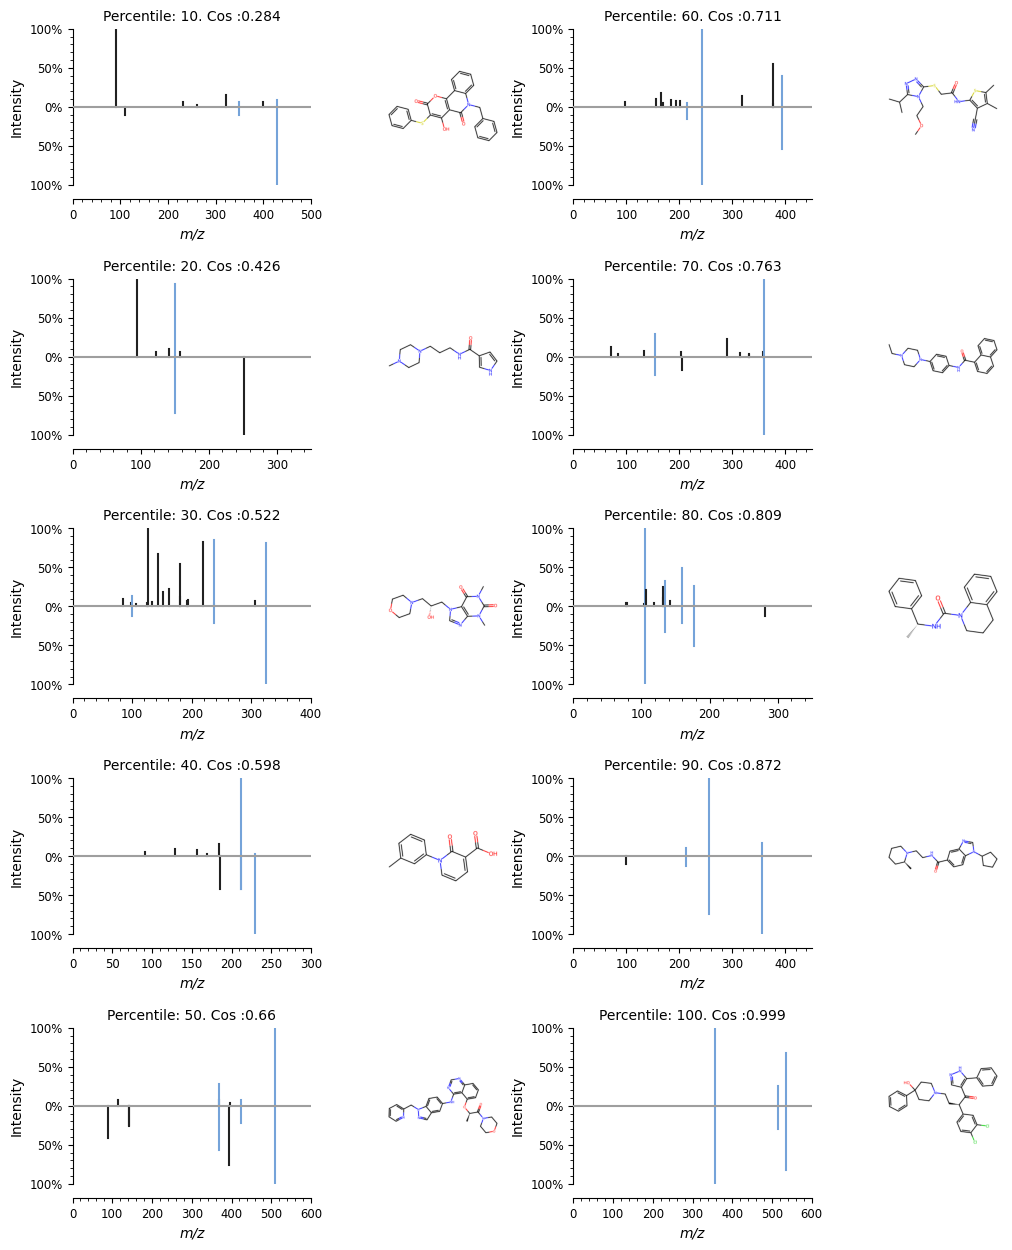

In [24]:

def plot_percentile(df,p_range, metric, start, end):
           # reset_matplotlib()
            indexes=[]
            m,n=0,0
            for i in p_range:
                indexes.append(get_percentile(df,i, metric))
            
            fig, axs = plt.subplots(5,4,figsize=(12,15), gridspec_kw={'width_ratios': [2, 1,2,1]}, sharey=False)#, sharex=True, sharey=True)
    
            for j,index in enumerate(indexes):
                
                data=df.iloc[index,:]
                print(j,data["SMILES"])
                ax = sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, ax=axs[m,n], highlight_matches=True)
                img = data["Metabolite"].draw(ax= axs[m,n+1])
                axs[m,n].set_title("Percentile: "+ str(p_range[j])+". Cos :"+str(round(data[metric],3)), fontsize=10)
                if j<4:
                    n=0
                    m=m+1
                if j==4:
                    m=0
                    n=2
                if j>4:
                    n=2
                    m=m+1
            plt.subplots_adjust( wspace=0.4,hspace=0.6)
            plt.show()
plot_percentile(df_test, [10,20,30,40,50,60,70,80,90,100], "spectral_sqrt_cosine" , 1, 10)        
#plot_percentile(df_cas, [10,20,30,40,50,60,70,80,90,100], "spectral_sqrt_cosine" , 1, 10) 
#plot_percentile(df_test, [20,40,60,80,100], "spectral_sqrt_cosine" , 1, 10)  

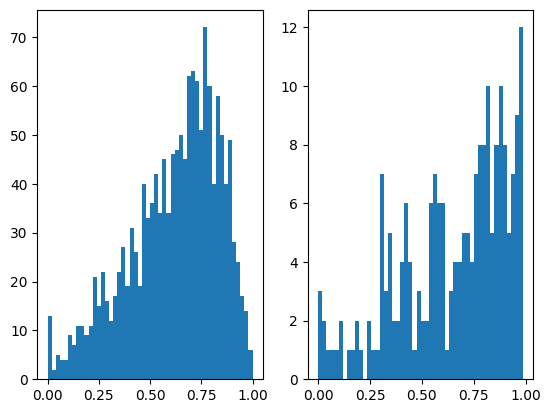

In [22]:
#reset_matplotlib()
fig, axs=plt.subplots(1,2)
axs[0].hist(df_test["spectral_sqrt_cosine"], bins=50)
axs[1].hist(df_cas["spectral_sqrt_cosine"], bins=50)

plt.show()

'CN1C(=O)Oc2cc(ccc12)S(=O)(=O)N3CCC(CC3)C(=O)Nc4nccs4'

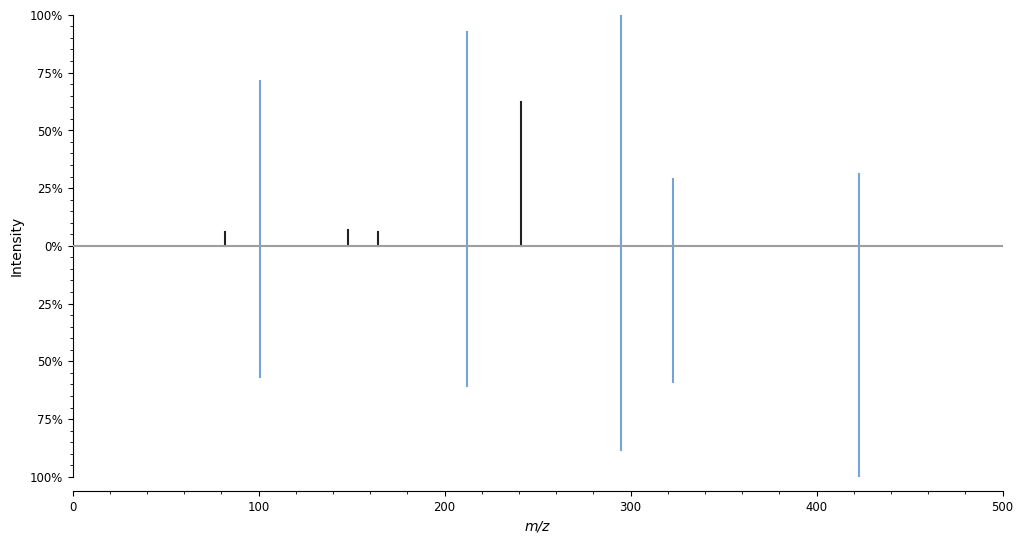

In [23]:

data=df_test.sort_values(by="spectral_sqrt_cosine").iloc[-180,:]
ax = sv.plot_spectrum(data, {"peaks": data["sim_peaks"]},  highlight_matches=True)
#print(data["spectral_sqrt_cosine"],data["SMILES"],data["PrecursorMZ"])
data["SMILES"]

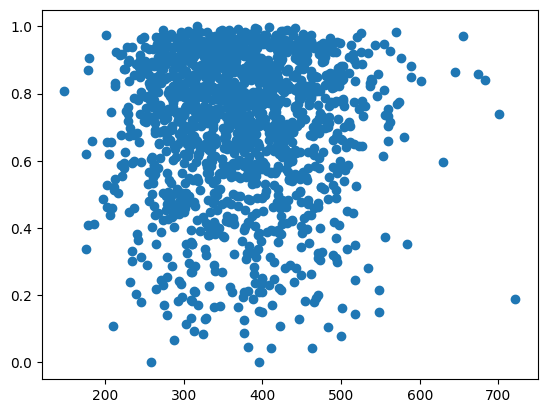

In [125]:
plt.scatter(df_test["PrecursorMZ"],df_test["spectral_sqrt_cosine"])
#plt.scatter(df_test['Well'],df_test["spectral_sqrt_cosine"])

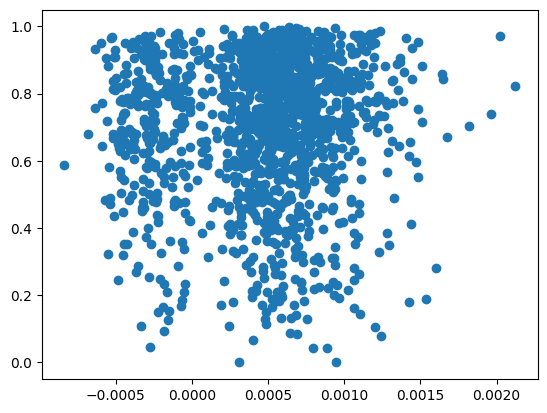

In [126]:
plt.scatter(df_test["M"]-df_test["Target"],df_test["spectral_sqrt_cosine"])


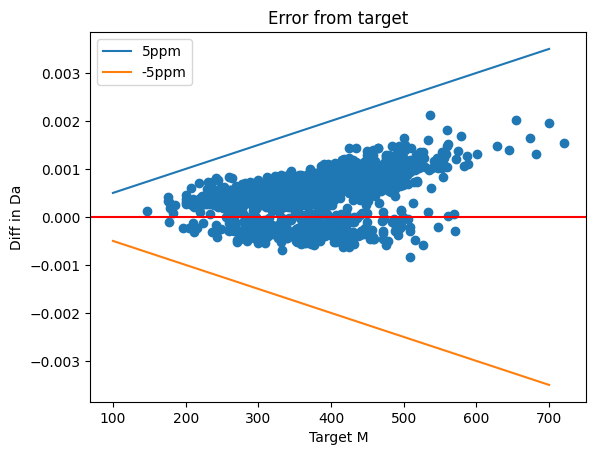

In [127]:
data=df_test
x=np.linspace(100,700)
y=x*5*10**-6
plt.scatter(data["Target"],data["M"]-data["Target"])
plt.ylabel("Diff in Da")
plt.xlabel("Target M")
plt.title("Error from target")
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(x,y,label="5ppm")
plt.plot(x,-y,label="-5ppm")
plt.legend()

In [128]:
# Default score
score = "spectral_sqrt_cosine"
#^score = "spectral_sqrt_cosine_wo_prec"
avg_func = np.mean

fiora_res = {"model": "Fiora", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score]), "Test-": avg_func(df_test[df_test["Precursor_type"] == "[M-H]-"][score]), "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score]), "CASMI16-":avg_func(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score])}#, "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score]), "CASMI22-": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score])} 
             
summaryPos = pd.DataFrame( [fiora_res])#, cfm_id, ice_res])
print("Summary test sets")
summaryPos

Summary test sets


,model,Test+,Test-,CASMI16+,CASMI16-
0,Fiora,0.709341,NaN,0.560498,0.336791


In [99]:
!python train_model_GraphConv.py -i ../plate20250408_5ppm_preprocessed_rounded_3dec.csv -l 0.001 -e 50 -t "test_CGConv" -m ../Checkpoints/checkpoint_Mona_only.best.pt

[09:05:23] WARNING: not removing hydrogen atom without neighbors
[09:05:23] WARNING: not removing hydrogen atom without neighbors
[09:05:23] WARNING: not removing hydrogen atom without neighbors
Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
Filtering based on CE and weight
Filtering spectra (14846) down to 14846
Filtering low peak counts
Removed  0 due to less than 2 peaks
Split into training, testing and validation
Running on device: cuda:0
Training model
dataset
test           1471
train         11760
validation     1471
Name: group_id, dtype: int64
Prepared training/validation with 13366 data points
<generator object Module.parameters at 0x7131696d6180>
Using pre-arranged train/validation set
/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer th

In [ ]:
GraphConv: 0.7599116974232152                 0.7611737159539886
GAT:0.7600513072615336                        0.7647482355827451
RGCNConv:0.7599032512361523                   0.7643257263094405
TransformerConv:0.7592176409096589            0.7644889608983336
CGConv: 0.7607461061662415                    0.7626041546699855